#### Project Kojak - Weeks 09 - 12

# _Speaker Recognition_, by Steven Bierer

## Audio File Loading
(Jupyter Notebook 1 of 4)

### This notebook.

Mainly this notebook contains my initial code to explore the TIMIT audio corpus. More recent versions of some of the code can be found in the Python file Speech_Analysis.py.

In [1]:
import numpy as np
import glob

import pyaudio 
import wave
import soundfile as sf

import librosa, librosa.display
from scipy.fftpack import fft
from scipy import signal

In [38]:
# Look at a sample audio file #
WAVBASE = r'data/TRAIN/'
WAVFILE = r'DR4/MAEB0/SX450.WAV'

wav, srate = sf.read(WAVBASE+WAVFILE)  # this works! srate = 16000

In [39]:
# Listen to the audio .wav file #
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1, rate=srate,
                frames_per_buffer=1024,
                output=True, output_device_index=1
                )

stream.write(wav.astype(np.float32).tostring())
stream.stop_stream() 
stream.close()

p.terminate()

In [4]:
# Define a spectrogram (converted to )
def log_spectrogram(audio, sample_rate, window_size=40, nfft=None,
                 step_size=20, eps=1e-10, freq_lim=None):
    """Adapted from https://www.kaggle.com/davids1992/
    speech-representation-and-data-exploration
    """
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nfft=nfft,
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    
    if freq_lim:
        fa_idx = freqs.searchsorted(freq_lim[0])
        fb_idx = min(freqs.searchsorted(freq_lim[1]),len(freqs)-1)
        freqs = freqs[fa_idx:fb_idx+1]
        spec = spec[fa_idx:fb_idx+1,:]
        print(f'Spectrogram truncated to {fb_idx-fa_idx+1} frequency bins.')
    
    return freqs, times, np.log(spec.astype(np.float32) + eps)

In [40]:
# Create spectrogram as #freq bins x #time bins array #
freqs, times, spectrogram = log_spectrogram(wav, srate, freq_lim=(0,6000))

Spectrogram truncated to 241 frequency bins.


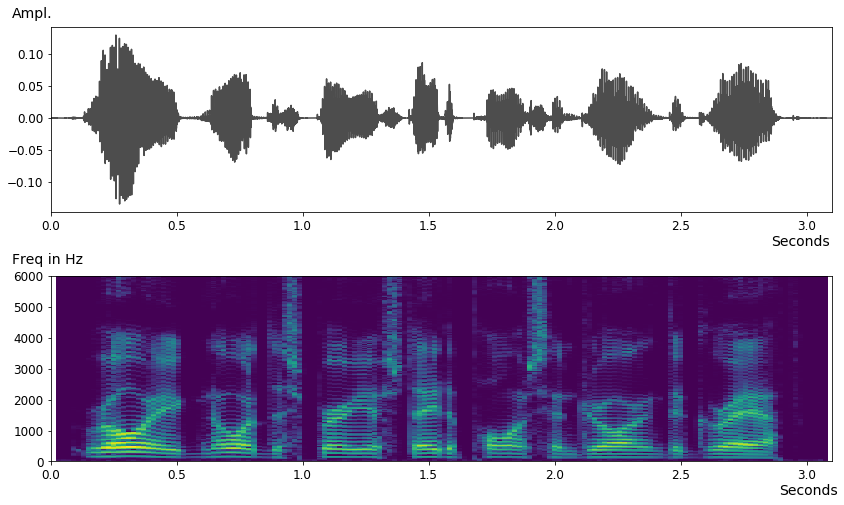

In [41]:
# Plot the audio waveform and spectrogram #
import matplotlib.pyplot as plt
%matplotlib inline

tt = np.linspace(0, len(wav)/srate, len(wav), endpoint=False)

fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=.34)
                    
ax1 = fig.add_subplot(211)
ax1.plot(tt, wav, color=(.3,.3,.3))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])

ax1.set_xlim(0,round(max(tt),2))
ax1.set_xlabel('Seconds', fontsize=14);
ax1.xaxis.set_label_coords(0.96, -0.12)
ax1.set_ylabel('Ampl.', fontsize=14, rotation=0, horizontalalignment='left')
ax1.yaxis.set_label_coords(-0.05, 1.03)

ax1.tick_params(axis='both',labelsize=12)
ax1.set_title('Raw wave of ' + WAVFILE)

ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(0,round(max(tt),2))
ax2.set_xlabel('Seconds', fontsize=14);
ax2.xaxis.set_label_coords(0.97, -0.12)
ax2.set_ylabel('Freq in Hz', fontsize=14, rotation=0, horizontalalignment='left')
ax2.yaxis.set_label_coords(-0.05, 1.05)

ax2.tick_params(axis='both', labelsize=12)
ax2.set_title('Spectrogram of ' + WAVFILE)

ax1.set_title(''); ax2.set_title('');

fig.savefig('graphics/AudioExample.png', dpi=300)

### Test of extracting all .wav files for a given speaker ###

In [42]:
# For given region/speaker, get a list of all audio files #
WREGION = 'DR4'
WSPEAKER = 'MAEB0'
WREGION = 'DR2'
WSPEAKER = 'FCAJ0'

In [43]:
wavdir = WAVBASE + '/'.join((WREGION,WSPEAKER))
wavlist = glob.glob(wavdir+'/*.WAV')

wavlist

['data/TRAIN/DR2/FCAJ0/SI849.WAV',
 'data/TRAIN/DR2/FCAJ0/SX39.WAV',
 'data/TRAIN/DR2/FCAJ0/SI1479.WAV',
 'data/TRAIN/DR2/FCAJ0/SX129.WAV',
 'data/TRAIN/DR2/FCAJ0/SI1804.WAV',
 'data/TRAIN/DR2/FCAJ0/SX399.WAV',
 'data/TRAIN/DR2/FCAJ0/SA2.WAV',
 'data/TRAIN/DR2/FCAJ0/SA1.WAV',
 'data/TRAIN/DR2/FCAJ0/SX219.WAV',
 'data/TRAIN/DR2/FCAJ0/SX309.WAV']

### Quick test of nonnegative matrix factorization ###

In [45]:
from sklearn.decomposition import NMF

In [46]:
# Run NMF on the spectrogram with 6 components #
# Note, my nomenclature here is different than in the .py file.
nmf_model = NMF(6, solver='mu', beta_loss='kullback-leibler')
spmin = spectrogram.min()   # W -> freq x components(k)
W = nmf_model.fit_transform((spectrogram+abs(spmin)))
H = nmf_model.components_   # H -> components(k) x time

# Wnew = transform(Xnew)
wnorm = np.linalg.norm(W)
W = W / wnorm
H = H * wnorm

print(W.shape,H.shape)

(241, 6) (6, 154)


In [47]:
spectrogram.T.shape

(154, 241)

In [49]:
# Repeat, but with W and H switched around in the NMF! It still works. #
nmf_model2 = NMF(6, solver='mu', beta_loss='kullback-leibler')
spmin = spectrogram.min()     # W -> freq x components(k)
H2 = nmf_model2.fit_transform((spectrogram+abs(spmin)).T)
W2 = nmf_model2.components_   # H -> components(k) x time

# W2 = transform(X2)
wnorm = np.linalg.norm(W2.T)
W2 = W2.T / wnorm
H2 = H2.T * wnorm

print(W2.shape,H2.shape)

(241, 6) (6, 154)


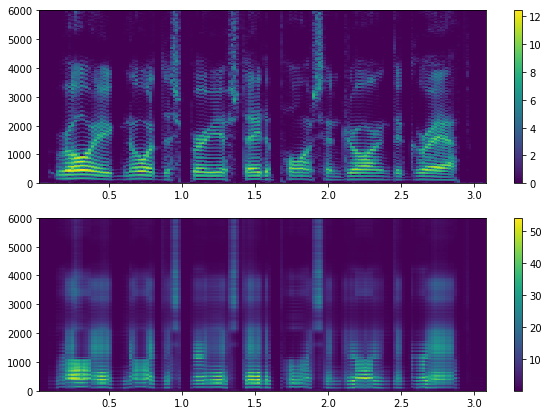

In [50]:
# Test to make sure this will invert back to the spectrogram #
nmf_model2.components_ = (W*wnorm*4).T  # playing around; result is 4x !
Xinv = nmf_model2.inverse_transform((H.T)/wnorm)

fig, axset = plt.subplots(2, 1, figsize=(10,7))

plt.sca(axset[0]);
plt.imshow((spectrogram+abs(spmin)), aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()]);
plt.colorbar();

plt.sca(axset[1]);  # W.dot(H) works also
plt.imshow(Xinv.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()]);
plt.colorbar();

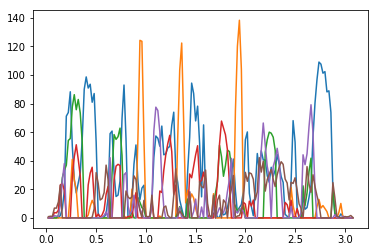

In [51]:
# Look at the temporal activations; the high-frequency components are noticable #
plt.plot(times,H.T);

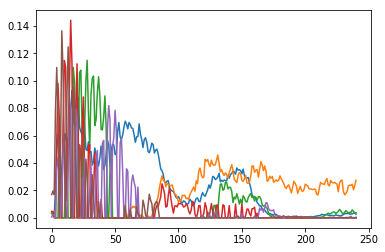

In [52]:
# Also look at the spectral components #
plt.plot(W);

### Quick test of MFCC ###

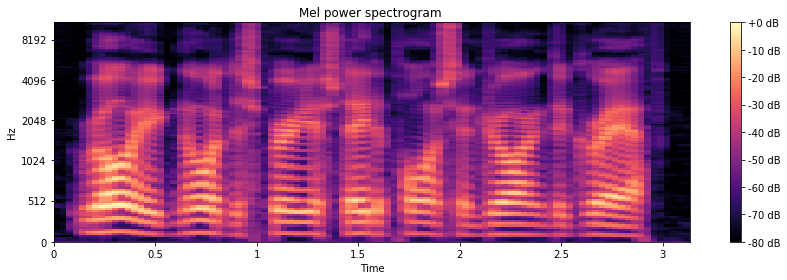

In [22]:
SSmel = librosa.feature.melspectrogram(wav, sr=srate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
SSmel_log = librosa.power_to_db(SSmel, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(SSmel_log, sr=srate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/Users/neuromac/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


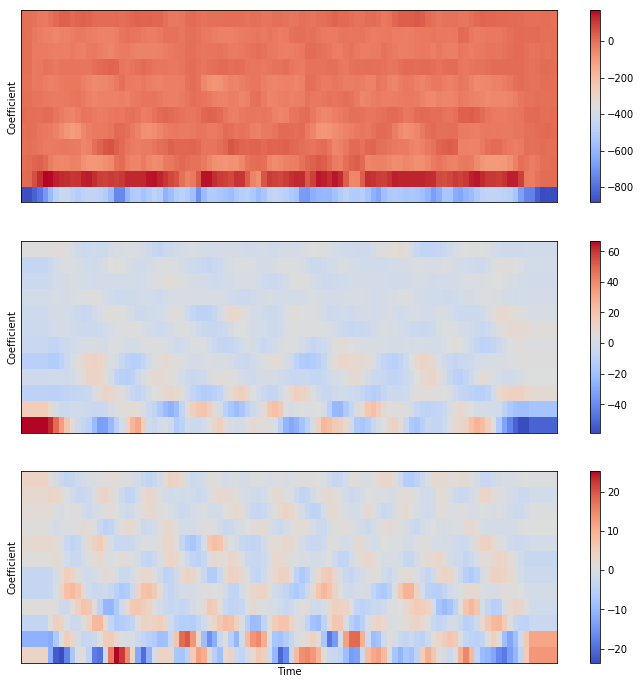

In [37]:
mfcc = librosa.feature.mfcc(S=SSmel_log, n_mfcc=12)
mfcc_d1 = librosa.feature.delta(mfcc, order=1, axis=1, width=9)  # delta
mfcc_d2 = librosa.feature.delta(mfcc, order=2, axis=1, width=9)  # delta-delta

fig, axset = plt.subplots(3, 1, figsize=(12,12))

plt.sca(axset[0]);
librosa.display.specshow(mfcc); plt.colorbar();
plt.sca(axset[1]);
librosa.display.specshow(mfcc_d1); plt.colorbar();
plt.sca(axset[2]);
librosa.display.specshow(mfcc_d2); plt.colorbar();

plt.setp(axset,ylabel='Coefficient');
axset[2].set_xlabel('Time');

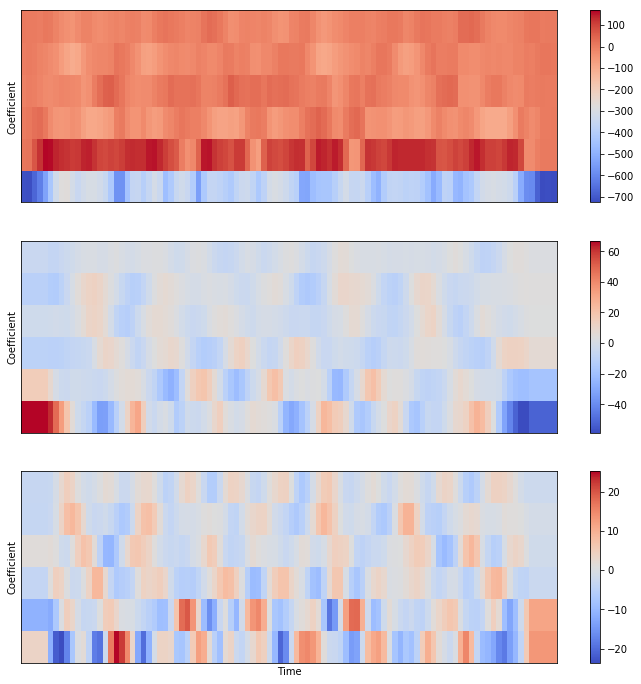

In [41]:
# mfcc0 = librosa.feature.mfcc(S=spectrogram, n_mfcc=12)
mfcc0 = librosa.feature.mfcc(wav, sr=srate, n_mfcc=6)
mfcc0_d1 = librosa.feature.delta(mfcc0, order=1, axis=1, width=9)  # delta
mfcc0_d2 = librosa.feature.delta(mfcc0, order=2, axis=1, width=9)  # delta-delta

fig, axset = plt.subplots(3, 1, figsize=(12,12))

plt.sca(axset[0]);
librosa.display.specshow(mfcc0); plt.colorbar();
plt.sca(axset[1]);
librosa.display.specshow(mfcc0_d1); plt.colorbar();
plt.sca(axset[2]);
librosa.display.specshow(mfcc0_d2); plt.colorbar();

plt.setp(axset,ylabel='Coefficient');
axset[2].set_xlabel('Time');